## Utils

In [240]:
import os

import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Importing the Data

In [241]:
columns = [
    "age", "workclass", "fnlwgt", "education", "education-num",
    "marital-status", "occupation", "relationship", "race", "sex",
    "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"
]

file_path = os.path.join("adult", "adult.data")

df = pd.read_csv(
    file_path,
    names=columns,
    sep=',',
    na_values='?',
    skipinitialspace=True
)


## Visualizing the Data

/var/folders/86/vnwv0vm95437pgydx0sm7wb80000gn/T/ipykernel_30716/1496946020.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='income', data=df, palette='viridis')


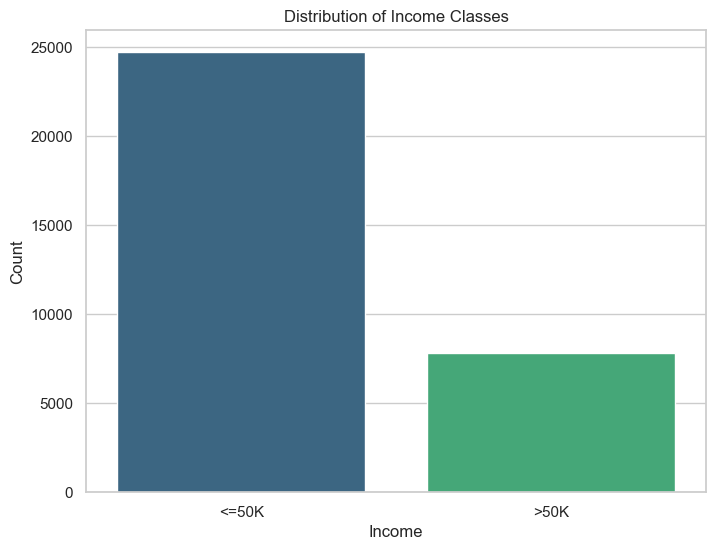

In [242]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.countplot(x='income', data=df, palette='viridis')
plt.title('Distribution of Income Classes')
plt.xlabel('Income')
plt.ylabel('Count')
plt.show()

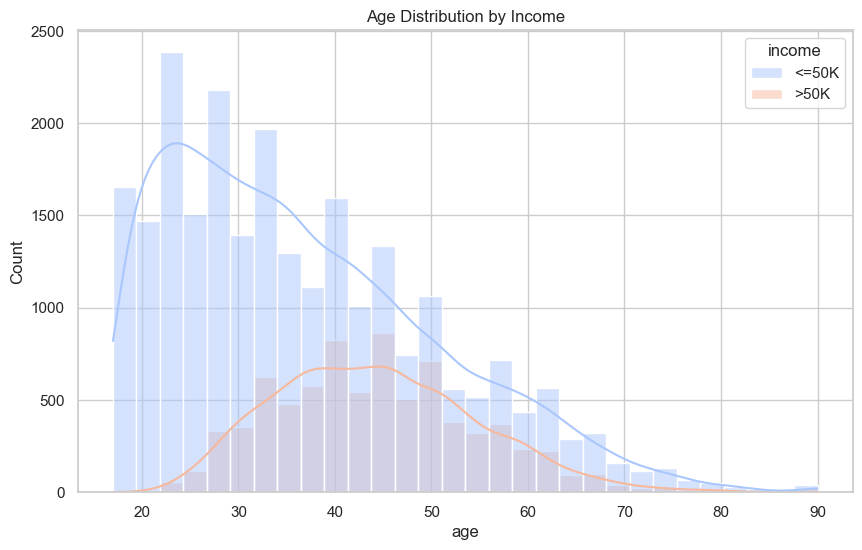

In [243]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='age', hue='income', bins=30, kde=True, palette='coolwarm')
plt.title('Age Distribution by Income')
plt.show()

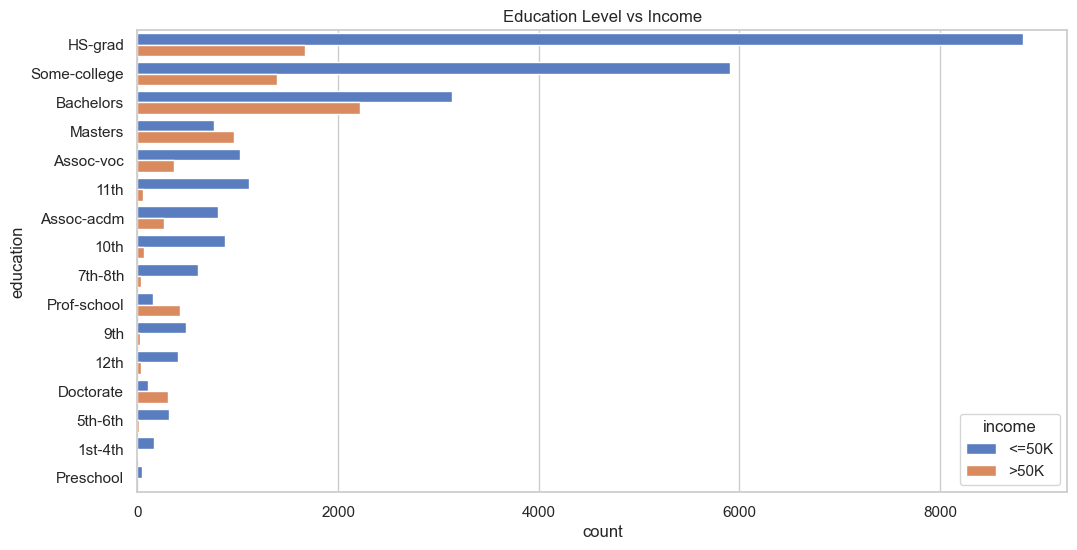

In [244]:
plt.figure(figsize=(12, 6))
sns.countplot(y='education', data=df, order=df['education'].value_counts().index, hue='income', palette='muted')
plt.title('Education Level vs Income')
plt.show()

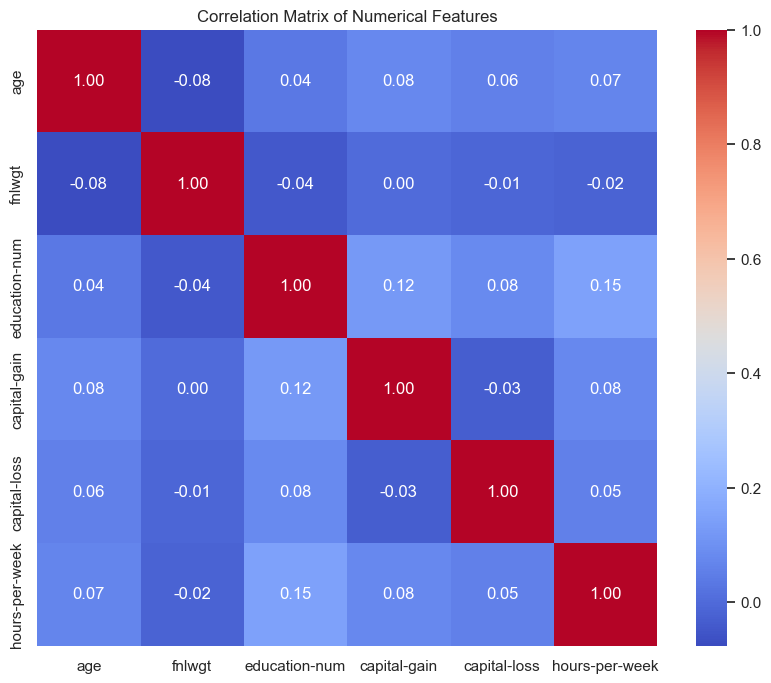

In [245]:
numeric_df = df.select_dtypes(include=['number'])

plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

## Data Prossecing

In [246]:
X = df.drop('income', axis=1) #Features without the income colum
y=df['income'] #Target

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: (32561, 14)
Target shape: (32561,)


In [247]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Training samples: 26048
Testing samples: 6513


## Confusion Matrix

In [248]:
def evaluate_model(model, X_test, y_test, title="Confusion Matrix"):
    """
    Generates predictions, calculates accuracy, and plots the confusion matrix.
    
    Parameters:
    - model: The trained model
    - X_test: The test features
    - y_test: The true test labels
    - title: Title for the plot
    """
    
    # 1. Generate Predictions
    predictions = model.predict(X_test)
    
    # 2. Print Accuracy Score
    acc = accuracy_score(y_test, predictions)
    print(f"Model Accuracy: {acc:.2%}")
    
    # 3. Create and Plot Confusion Matrix
    cm = confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    
    plt.figure(figsize=(8, 6))
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"{title}\n(Accuracy: {acc:.2%})")
    plt.grid(False) 
    plt.show()

## Gaussian Naive Bayes

In [249]:
def calculate_log_priors(y_target):
    """
    Calculates the log priors for each class in the target series.
    """
    class_counts = y_target.value_counts()
    total_samples = len(y_target)
    priors = class_counts / total_samples
    log_priors = np.log(priors)
    
    return log_priors

In [250]:
def calculate_log_gaussian(x, mean, std):
    """
    Calculates the log of the Gaussian PDF.
    
    Parameters:
    - x: The value(s) you want to test (e.g., a person's age).
    - mean: The average of the feature for a specific class.
    - var: The variance of the feature for a specific class.
    """
    epsilon = 1e-9 
    
    # Formula terms split for clarity:
    # Term 1: -0.5 * ln(2 * pi * variance)
    term1 = -0.5 * np.log(2 * np.pi * std**2 + epsilon)
    
    # Term 2: - (x - mean)^2 / (2 * variance)
    term2 = -((x - mean) ** 2) / (2 * std**2 + epsilon)
    
    return term1 + term2

In [251]:
# 1. Define the continuous features based on the dataset documentation
# [cite: 48, 49, 51, 52]
continuous_cols = [
    'age', 
    'fnlwgt', 
    'education-num', 
    'capital-gain', 
    'capital-loss', 
    'hours-per-week'
]

# 2. Combine X_train and y_train temporarily to use GroupBy
train_data = X_train.copy()
train_data['income'] = y_train

# 3. Compute Mean and Standard Deviation
df_means = train_data.groupby('income')[continuous_cols].mean()
df_stds = train_data.groupby('income')[continuous_cols].std()

# 4. Convert to NumPy Arrays of shape (K, M)
means_array = df_means.to_numpy()
stds_array = df_stds.to_numpy()

print("Means Array Shape:", means_array.shape) 
print("Stds Array Shape:", stds_array.shape)    

print("\nMeans Array (Rows=Classes, Cols=Features):")
print(means_array)

Means Array Shape: (2, 6)
Stds Array Shape: (2, 6)

Means Array (Rows=Classes, Cols=Features):
[[3.68031353e+01 1.90704271e+05 9.59261694e+00 1.49522023e+02
  5.40749431e+01 3.88880405e+01]
 [4.42203093e+01 1.87787513e+05 1.16150167e+01 3.93302503e+03
  1.95054360e+02 4.55015144e+01]]


In [252]:
def calculate_gaussian_log_likelihood(X_continuous, means, stds):
    """
    Calculates the log likelihood of continuous data given class statistics.
    
    Parameters:
    - X_continuous: Array of shape (N_samples, M_features) containing the data.
    - means: Array of shape (K_classes, M_features).
    - stds: Array of shape (K_classes, M_features).
    
    Returns:
    - log_likelihoods: Array of shape (N_samples, K_classes).
    """
    N, M = X_continuous.shape
    K = means.shape[0]
    
    # Initialize the output array
    log_likelihoods = np.zeros((N, K))
    
    # Epsilon to prevent division by zero or log(0)
    epsilon = 1e-9
    
    # Loop over each class (K) to calculate that class's likelihood score
    for k in range(K):
        # Extract mean and std for this specific class (shape: M,)
        mu_k = means[k, :]
        sigma_k = stds[k, :] + epsilon
        
        # 1. Calculate the log of the coefficient: -0.5 * log(2 * pi) - log(sigma)
        # We sum over M features because Naive Bayes assumes features are independent
        # (log(P(f1) * P(f2)) = log(P(f1)) + log(P(f2)))
        coeff_term = -0.5 * np.log(2 * np.pi) - np.log(sigma_k)
        
        # 2. Calculate the exponential term: - (x - mu)^2 / (2 * sigma^2)
        # Note: (X_continuous - mu_k) broadcasts shape (N, M) - (M,) -> (N, M)
        exponent_term = -0.5 * ((X_continuous - mu_k) ** 2) / (sigma_k ** 2)
        
        # 3. Combine and sum across all features (axis=1) to get total score for this class
        # shape changes from (N, M) -> (N,)
        class_log_prob = np.sum(coeff_term + exponent_term, axis=1)
        
        # Store in the result column for this class
        log_likelihoods[:, k] = class_log_prob
        
    return log_likelihoods

In [253]:
def calculate_categorical_log_likelihood(X_categorical, likelihood_dict, classes):
    N = X_categorical.shape[0]
    K = len(classes)
    log_likelihoods = np.zeros((N, K))
    
    # Loop through each categorical feature
    for col in X_categorical.columns:
        # Retrieve the pre-calculated log-prob table for this column
        prob_df = likelihood_dict[col]
        
        # For each class, map the text values in X (e.g., "Bachelors") 
        # to their log-probability score
        for i, c_label in enumerate(classes):
            # map() replaces the text with the number. fillna handles unseen values.
            # We use a small log-prob (-20) for unseen values to avoid crashing.
            mapped_probs = X_categorical[col].map(prob_df[c_label]).fillna(-20).values
            log_likelihoods[:, i] += mapped_probs
            
    return log_likelihoods

In [254]:
# --- 1. Calculate Log Priors ---
# You defined the function, now you must use it on y_train
log_priors = calculate_log_priors(y_train)

# --- 2. Calculate Categorical Likelihoods ---
# You need this helper function (from our previous discussion) to build the dictionary
def build_categorical_likelihoods(X_train, y_train, categorical_cols, classes, alpha=1.0):
    likelihood_dict = {}
    train_df = X_train.copy()
    train_df['income'] = y_train
    
    for col in categorical_cols:
        probs = {}
        unique_vals = train_df[col].unique()
        
        for c in classes:
            class_subset = train_df[train_df['income'] == c]
            total_in_class = len(class_subset)
            counts = class_subset[col].value_counts()
            counts = counts.reindex(unique_vals, fill_value=0)
            
            # Laplace smoothing
            prob = (counts + alpha) / (total_in_class + alpha * len(unique_vals))
            probs[c] = np.log(prob)
            
        likelihood_dict[col] = pd.DataFrame(probs)
    return likelihood_dict

cat_likelihoods = build_categorical_likelihoods(
    X_train, 
    y_train, 
    cat_cols, 
    classes=class_labels
)

print("Training statistics calculated successfully.")

Training statistics calculated successfully.


In [255]:
log_priors_values = log_priors.values  

# 2. Update the predict function to handle input types safely
def predict_naive_bayes(X, continuous_cols, categorical_cols, means, stds, log_priors, categorical_likelihoods, classes):
    
    # Ensure log_priors is a numpy array for broadcasting
    if isinstance(log_priors, pd.Series):
        log_priors = log_priors.values
        
    # 1. Continuous Log-Likelihoods
    X_cont = X[continuous_cols].values
    gauss_ll = calculate_gaussian_log_likelihood(X_cont, means, stds)
    
    # 2. Categorical Log-Likelihoods
    X_cat = X[categorical_cols]
    cat_ll = calculate_categorical_log_likelihood(X_cat, categorical_likelihoods, classes)
    
    # 3. Sum Everything
    # Now this broadcasting works: (2,) adds to (6513, 2)
    total_log_likelihood = log_priors + gauss_ll + cat_ll
    
    # 4. Predict
    predictions_indices = np.argmax(total_log_likelihood, axis=1)
    return classes[predictions_indices]

## Test

In [256]:
# 1. Define Column Types
cont_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
cat_cols = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
class_labels = np.array(['<=50K', '>50K'])

# 2. (Assumption) You have calculated 'means_array', 'stds_array', 'log_priors'
# and a dictionary 'cat_likelihoods' containing the probability tables for each text column.

# 3. Predict on Test Set
y_pred = predict_naive_bayes(
    X=X_test,
    continuous_cols=cont_cols,
    categorical_cols=cat_cols,
    means=means_array,
    stds=stds_array,
    log_priors=log_priors,
    categorical_likelihoods=cat_likelihoods,
    classes=class_labels
)

# 4. Check Accuracy
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.836480884385076


<Figure size 800x600 with 0 Axes>

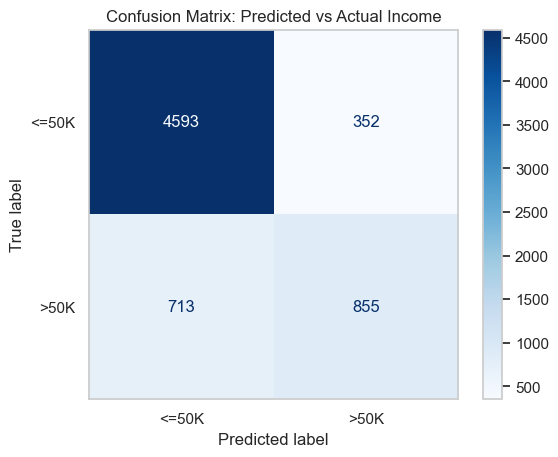

In [257]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    
    plt.figure(figsize=(8, 6))
    disp.plot(cmap='Blues', values_format='d')
    plt.title('Confusion Matrix: Predicted vs Actual Income')
    plt.grid(False)
    plt.show()

# Run it
plot_confusion_matrix(y_test, y_pred, class_labels)

## Neural Network

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

def preprocess_data(df):
    """
    Preprocesses data for a Neural Network:
    1. Converts categorical columns to numbers (Label Encoding).
    2. Separates Features (X) and Target (y).
    3. Splits into Train (80%), Validation (10%), and Test (10%).
    4. Standardizes the feature data (Mean=0, Std=1).
    
    Returns:
    - Tuple of NumPy arrays: (X_trn, y_trn, X_vld, y_vld, X_tst, y_tst)
    """
    # Create a copy to avoid modifying the original dataframe
    data = df.copy()
    
    # 1. Encode Categorical Data 
    le = LabelEncoder()
    for col in data.select_dtypes(include=['object']).columns:
        data[col] = le.fit_transform(data[col])
        
    # 2. Separate Data (X) and Labels (y)
    X = data.drop('income', axis=1).values
    y = data['income'].values
    
    # 3. Split Data: Train, Validation, Test
    # First Split: 80% Train, 20% Temporary (to be split into Val/Test)
    X_trn, X_temp, y_trn, y_temp = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Second Split: Split the 20% Temp into 50% Validation (10% total) and 50% Test (10% total)
    X_vld, X_tst, y_vld, y_tst = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )
    
    # 4. Standardize the Data (X)
    scaler = StandardScaler()
    
    X_trn = scaler.fit_transform(X_trn) # Learn mean/std from train and transform
    X_vld = scaler.transform(X_vld)     # Apply train mean/std to validation
    X_tst = scaler.transform(X_tst)     # Apply train mean/std to test
    
    return X_trn, y_trn, X_vld, y_vld, X_tst, y_tst

X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = preprocess_data(df)

print(f"Training Shape:   {X_trn.shape}")
print(f"Validation Shape: {X_vld.shape}")
print(f"Testing Shape:    {X_tst.shape}")

Training Shape:   (26048, 14)
Validation Shape: (3256, 14)
Testing Shape:    (3257, 14)


In [259]:
class Linear:
    @staticmethod
    def activation(z):
        """
        The linear/identity activation function.
        It simply returns the input as is.
        """
        return z

    @staticmethod
    def derivative(z):
        """
        The derivative of the linear activation function.
        Since f(z) = z, the derivative f'(z) = 1.
        Returns an array of ones with the same shape as the input z.
        """
        return np.ones_like(z)

In [260]:
class Tanh:
    @staticmethod
    def activation(z):
        """
        The tanh activation function.
        Transforms input z to the range (-1, 1).
        """
        return np.tanh(z)

    @staticmethod
    def derivative(z):
        """
        The derivative of the tanh activation function.
        Formula: 1 - tanh(z)^2
        """
        return 1 - np.tanh(z)**2

In [261]:
def init_weights(layer_sizes):
    """
    Initializes weights and biases using Xavier/Glorot initialization.
    
    Parameters:
    - layer_sizes: A list containing the size of each layer. 
                   Example: [4, 10, 3] means:
                   - Input layer: 4 neurons
                   - Hidden layer: 10 neurons
                   - Output layer: 3 neurons
    
    Returns:
    - params: A dictionary containing initialized 'W' and 'b' for each layer.
              Keys are 'W1', 'b1', 'W2', 'b2', etc.
    """
    params = {}
    
    # Loop through the layers to initialize weights between them
    for i in range(len(layer_sizes) - 1):
        
        n_in = layer_sizes[i]       # Number of neurons in the previous layer
        n_out = layer_sizes[i + 1]  # Number of neurons in the current layer
        
        # --- Xavier / Glorot Initialization ---
        # We perform a standard normal distribution and scale it.
        # Scaling factor: sqrt(2 / (n_in + n_out))
        limit = np.sqrt(2 / (n_in + n_out))
        
        # Weight Matrix W: shape (n_in, n_out)
        params[f'W{i+1}'] = np.random.randn(n_in, n_out) * limit
        
        # Bias Vector b: shape (1, n_out)
        # Biases are typically initialized to zero.
        params[f'b{i+1}'] = np.zeros((1, n_out))
        
    return params

In [263]:
input_size = 14
hidden_layers = [100, 50]
output_size = 2

architecture = [input_size] + hidden_layers + [output_size]

parameters = init_weights(architecture)

print("W1 shape:", parameters['W1'].shape) # Should be (14, 100)
print("b1 shape:", parameters['b1'].shape) # Should be (1, 100)
print("W2 shape:", parameters['W2'].shape) # Should be (100, 50)
print("b2 shape:", parameters['b2'].shape) # Should be (1, 50)
print("W3 shape:", parameters['W3'].shape) # Should be (50, 2)

W1 shape: (14, 100)
b1 shape: (1, 100)
W2 shape: (100, 50)
b2 shape: (1, 50)
W3 shape: (50, 2)


In [267]:
def forward(X, params):
    """
    Parameters:
    - X: Input data array (shape: N_samples, N_features).
    - params: Dictionary containing initialized weights and biases ('W1', 'b1', 'W2', 'b2', ...).
    
    Returns:
    - output: The final output of the network.
    - cache: A dictionary containing Z and A values for every layer (needed for backprop).
    """
    cache = {}
    A = X  # 'A' represents the activation (input) for the current layer
    
    # Calculate number of layers (each layer has a W and a b, so divide by 2)
    num_layers = len(params) // 2

    cache['A0'] = X
    
    # --- Hidden Layers Loop ---
    for i in range(1, num_layers):
        W = params[f'W{i}']
        b = params[f'b{i}']
        
        # 1. Linear Step: Z = A . W + b
        Z = np.dot(A, W) + b
        
        # 2. Activation Step: A = Tanh(Z)
        A = Tanh.activation(Z)
        
        # 3. Cache values for backprop
        cache[f'Z{i}'] = Z
        cache[f'A{i}'] = A
        
    # --- Output Layer ---
    # The last layer typically uses a different activation (Linear/Identity for regression)
    W_out = params[f'W{num_layers}']
    b_out = params[f'b{num_layers}']
    
    # 1. Linear Step
    Z_out = np.dot(A, W_out) + b_out
    
    # 2. Activation Step (Linear/Identity)
    A_out = Linear.activation(Z_out)
    
    # 3. Cache values
    cache[f'Z{num_layers}'] = Z_out
    cache[f'A{num_layers}'] = A_out
    
    return A_out, cache

In [265]:
output, cache = forward(X_trn, parameters)

# 3. Verify
print("Output shape:", output.shape)  
print("Cache keys:", cache.keys())    

Output shape: (26048, 2)
Cache keys: dict_keys(['Z1', 'A1', 'Z2', 'A2', 'Z3', 'A3'])


In [269]:
def backward(y_true, y_pred, cache, params):
    grads = {}
    N = y_true.shape[0]
    num_layers = len(params) // 2
    
    # --- 1. Output Layer (Manual Step) ---
    # Assuming Linear Activation/MSE for output
    dZ = y_pred - y_true
    
    # Get input to the last layer
    A_prev = cache[f'A{num_layers-1}']
    
    # Calculate Last Layer Gradients
    grads[f'dW{num_layers}'] = (1 / N) * np.dot(A_prev.T, dZ)
    grads[f'db{num_layers}'] = (1 / N) * np.sum(dZ, axis=0, keepdims=True)
    
    # --- 2. Hidden Layers Loop ---
    # Iterate from second-to-last layer down to 1
    for i in range(num_layers - 1, 0, -1):
        
        # Prepare inputs for the helper function
        dZ_next = dZ  # The error we just calculated becomes "next" for the layer below
        W_next = params[f'W{i+1}'] # Weights connecting i to i+1
        Z_curr = cache[f'Z{i}']
        
        # Determine input (A_prev)
        if i == 1:
            A_prev = cache['A0'] # Original Input X
        else:
            A_prev = cache[f'A{i-1}']
            
        # Call the helper function
        dW, db, dZ = hidden_layer_grads(
            dZ_next, 
            W_next, 
            Z_curr, 
            A_prev, 
            Tanh.derivative # Pass the static method
        )
        
        # Store results
        grads[f'dW{i}'] = dW
        grads[f'db{i}'] = db
        
        # Update dZ for the next iteration of the loop
        # (The dZ returned above is for layer i, which becomes dZ_next for layer i-1)
        
    return grads

In [ ]:
# 1. Forward Pass
y_pred, cache = forward(X_trn, parameters)

# 2. Backward Pass
if y_trn.ndim == 1:
    y_trn = y_trn.reshape(-1, 1)

gradients = backward(y_trn, y_pred, cache, parameters)

# 3. Verify
print("Gradient dW1 shape:", gradients['dW1'].shape) # Should match W1 shape
print("Gradient db1 shape:", gradients['db1'].shape) # Should match b1 shape

Gradient dW1 shape: (14, 100)
Gradient db1 shape: (1, 100)


In [270]:
def hidden_layer_grads(dZ_next, W_next, Z_curr, A_prev, activation_deriv):
    """
    Calculates gradients for a specific hidden layer.
    
    Parameters:
    - dZ_next: Gradients of the loss w.r.t the Z of the next layer (layer l+1).
    - W_next: Weights connecting the current layer to the next layer (W_{l+1}).
    - Z_curr: Linear output of the current layer (Z_l).
    - A_prev: Activation of the previous layer (A_{l-1}), which is the input to this layer.
    - activation_deriv: The derivative function for the current layer (e.g., Tanh.derivative).
    
    Returns:
    - dW_curr: Gradient w.r.t. weights of the current layer.
    - db_curr: Gradient w.r.t. biases of the current layer.
    - dZ_curr: Gradient w.r.t. Z of the current layer (to be passed down to the previous layer).
    """
    N = dZ_next.shape[0]  # Number of samples
    
    # 1. Backpropagate the error from the next layer
    # We multiply the error from ahead (dZ_next) by the weights connecting back to us.
    error_signal = np.dot(dZ_next, W_next.T)
    
    # 2. Apply the derivative of the activation function
    # Element-wise multiplication (Hadamard product)
    dZ_curr = error_signal * activation_deriv(Z_curr)
    
    # 3. Calculate Gradients for Weights and Biases
    # dW = (1/N) * (Input.T dot Error)
    dW_curr = (1 / N) * np.dot(A_prev.T, dZ_curr)
    
    # db = (1/N) * sum(Error)
    db_curr = (1 / N) * np.sum(dZ_curr, axis=0, keepdims=True)
    
    return dW_curr, db_curr, dZ_curr

In [273]:
def get_batches(X, y, batch_size):
    """
    Yields mini-batches of data for training.
    
    Parameters:
    - X: Features (N_samples, N_features)
    - y: Labels (N_samples,)
    - batch_size: Size of each mini-batch
    """
    n_samples = X.shape[0]
    indices = np.arange(n_samples)
    
    # Shuffle indices to ensure random sampling
    np.random.shuffle(indices)
    
    # Iterate through the data in chunks of batch_size
    for i in range(0, n_samples, batch_size):
        batch_indices = indices[i:i + batch_size]
        yield X[batch_indices], y[batch_indices]

In [271]:
class NeuralNetwork():
    def __init__(self, layer_sizes):
        """
        Initializes the neural network.
        
        Parameters:
        - layer_sizes: List of layer dimensions (e.g., [14, 100, 50, 2])
        """
        self.layer_sizes = layer_sizes
        # Use the init_weights function you created earlier
        self.params = init_weights(layer_sizes)
        self.loss_history = []

    def fit(self, X_train, y_train, X_val=None, y_val=None, batch_size=32, epochs=10, lr=0.01):
        """
        Trains the network using Mini-Batch Gradient Descent.
        
        Parameters:
        - X_train, y_train: Training data
        - X_val, y_val: Validation data (optional, for monitoring)
        - batch_size: Size of mini-batches
        - epochs: Number of passes through the entire dataset
        - lr: Learning rate
        """
        # Ensure y_train is shaped correctly (N, 1) if it's currently (N,)
        if y_train.ndim == 1:
            y_train = y_train.reshape(-1, 1)
        if y_val is not None and y_val.ndim == 1:
            y_val = y_val.reshape(-1, 1)

        print(f"Starting training for {epochs} epochs...")

        for epoch in range(epochs):
            epoch_loss = 0
            num_batches = 0
            
            # --- Mini-Batch Loop ---
            for X_batch, y_batch in get_batches(X_train, y_train, batch_size):
                
                # 1. Forward Pass
                y_pred, cache = forward(X_batch, self.params)
                
                # 2. Backward Pass
                grads = backward(y_batch, y_pred, cache, self.params)
                
                # 3. Parameter Update (Gradient Descent Step)
                # W = W - lr * dW
                for i in range(1, len(self.layer_sizes)):
                    self.params[f'W{i}'] -= lr * grads[f'dW{i}']
                    self.params[f'b{i}'] -= lr * grads[f'db{i}']
                
                # Track training loss (MSE)
                batch_loss = np.mean((y_pred - y_batch) ** 2)
                epoch_loss += batch_loss
                num_batches += 1
            
            # --- End of Epoch Monitoring ---
            avg_train_loss = epoch_loss / num_batches
            self.loss_history.append(avg_train_loss)
            
            status = f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}"
            
            if X_val is not None and y_val is not None:
                # Calculate Validation Loss
                val_pred, _ = forward(X_val, self.params)
                val_loss = np.mean((val_pred - y_val) ** 2)
                status += f" - Val Loss: {val_loss:.4f}"
            
            print(status)

    def predict(self, X):
        """
        Generates predictions for input X.
        
        Returns:
        - predictions: Raw outputs from the network (regression values).
        """
        # We only need the output (y_pred), not the cache
        y_pred, _ = forward(X, self.params)
        return y_pred

## Test

In [276]:
# 1. Define Architecture
# Input: 14 features (from adult dataset)
# Hidden 1: 64 neurons
# Hidden 2: 32 neurons
# Output: 1 neuron (Binary regression target: 0 or 1)
model = NeuralNetwork([X_trn.shape[1], 64, 32, 1])

# 2. Train
model.fit(
    X_trn, y_trn, 
    X_val=X_vld, y_val=y_vld, 
    batch_size=64, 
    epochs=20, 
    lr=0.01
)

# 3. Predict
preds = model.predict(X_tst)

Starting training for 20 epochs...
Epoch 1/20 - Train Loss: 0.1518 - Val Loss: 0.1308
Epoch 2/20 - Train Loss: 0.1328 - Val Loss: 0.1277
Epoch 3/20 - Train Loss: 0.1302 - Val Loss: 0.1249
Epoch 4/20 - Train Loss: 0.1282 - Val Loss: 0.1234
Epoch 5/20 - Train Loss: 0.1265 - Val Loss: 0.1219
Epoch 6/20 - Train Loss: 0.1251 - Val Loss: 0.1210
Epoch 7/20 - Train Loss: 0.1239 - Val Loss: 0.1195
Epoch 8/20 - Train Loss: 0.1230 - Val Loss: 0.1185
Epoch 9/20 - Train Loss: 0.1219 - Val Loss: 0.1178
Epoch 10/20 - Train Loss: 0.1211 - Val Loss: 0.1170
Epoch 11/20 - Train Loss: 0.1204 - Val Loss: 0.1169
Epoch 12/20 - Train Loss: 0.1198 - Val Loss: 0.1165
Epoch 13/20 - Train Loss: 0.1192 - Val Loss: 0.1158
Epoch 14/20 - Train Loss: 0.1186 - Val Loss: 0.1153
Epoch 15/20 - Train Loss: 0.1182 - Val Loss: 0.1148
Epoch 16/20 - Train Loss: 0.1177 - Val Loss: 0.1143
Epoch 17/20 - Train Loss: 0.1173 - Val Loss: 0.1140
Epoch 18/20 - Train Loss: 0.1168 - Val Loss: 0.1142
Epoch 19/20 - Train Loss: 0.1165 - Val

In [282]:
def plot_training_results(model):
    """
    Plots the loss curve from the training history.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(model.loss_history, label='Training Loss')
    plt.title('Neural Network Training Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.grid(True)
    plt.legend()
    plt.show()

def evaluate_neural_network(model, X_test, y_test, class_names=['<=50K', '>50K']):
    """
    Evaluates the model on test data and plots the confusion matrix.
    """
    # 1. Get raw predictions (these are continuous numbers from the Linear output)
    raw_preds = model.predict(X_test)
    
    # 2. Convert to Class Labels
    final_preds = (raw_preds > 0.5).astype(int)
    
    # 3. Calculate Accuracy
    acc = accuracy_score(y_test, final_preds)
    print(f"Test Accuracy: {acc:.2%}")
    
    # 4. Plot Confusion Matrix
    cm = confusion_matrix(y_test, final_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    
    plt.figure(figsize=(8, 6))
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"Neural Network Confusion Matrix\n(Accuracy: {acc:.2%})")
    plt.grid(False)
    plt.show()

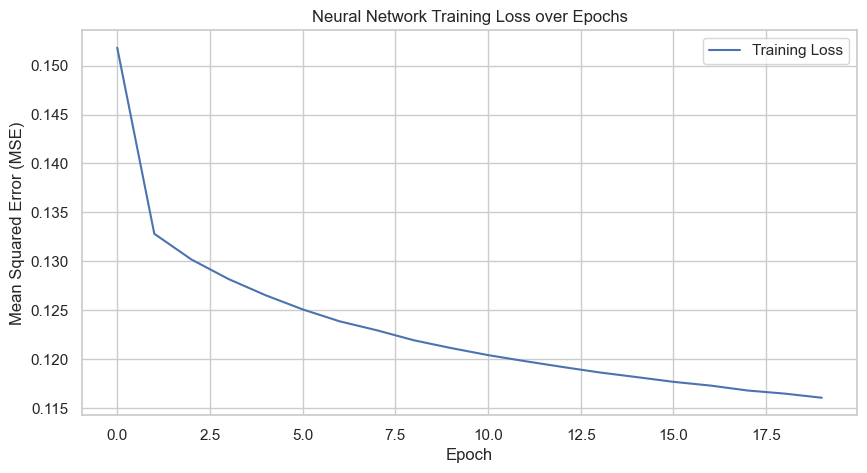

Test Accuracy: 84.00%


<Figure size 800x600 with 0 Axes>

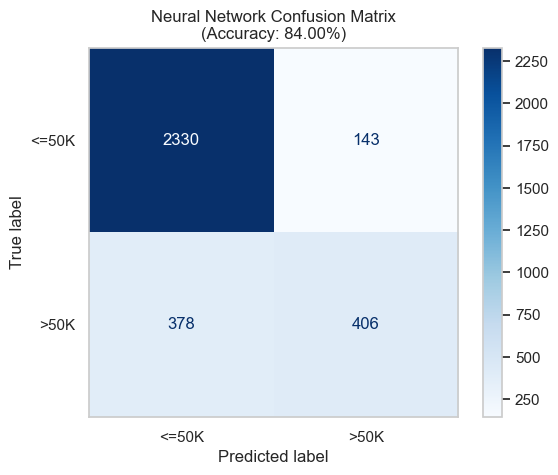

In [283]:
# 1. Visualize how the loss decreased during training
plot_training_results(model)

# 2. Visualize the final performance on the Test set
# Note: Ensure y_tst is the correct shape for the metric functions
evaluate_neural_network(model, X_tst, y_tst.flatten())